## Manually doing it

In [1]:
from nltk.tokenize import RegexpTokenizer
import pandas as pd
import langid
import re
import os
import nltk
from nltk.collocations import *
from itertools import chain
import itertools
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import MWETokenizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.probability import FreqDist
from nltk.tokenize import MWETokenizer
from lxml import etree
import pandas as pd
import numpy as np
import os
import re
import preprocessor as p
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from textblob import Word
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV


from nltk.util import ngrams
from itertools import chain
from nltk.probability import *
from nltk.tokenize import MWETokenizer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import TweetTokenizer

In [2]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

In [3]:
data = pd.read_csv('train_data_labels.csv')

In [4]:
from collections import Counter
# Counter(data['label'])

count_class = pd.value_counts(data['label'])
print(count_class)

cs                  9569
math.AG             1280
math.CO             1023
astro-ph.HE          864
math.AP              752
                    ... 
math.HO               16
physics.atm-clus      13
physics.pop-ph        11
nlin.CG               10
stat.OT                7
Name: label, Length: 100, dtype: int64


Text(0.5, 0, 'label')

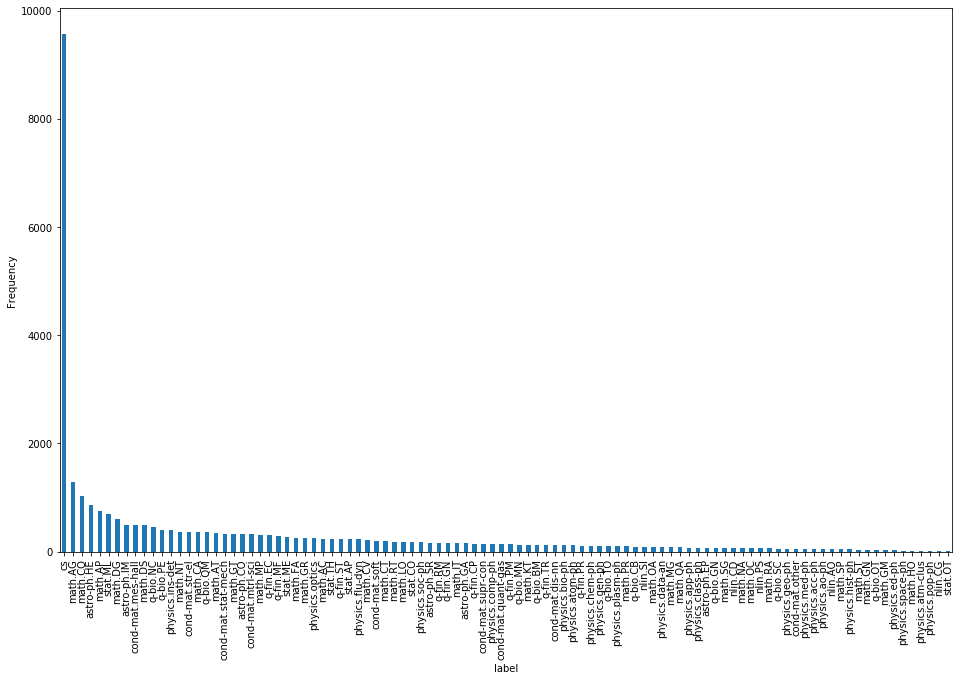

In [5]:
plt.figure(figsize=(16,10))
count_class.plot(kind='bar')
plt.ylabel('Frequency')
plt.xlabel('label')

In [6]:
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
sent_detector

In [7]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [8]:
stopwords_list = []
with open('stopwords_en.txt') as f:
    for line in f:
        stopwords_list.append(line.strip('\n'))
        

In [9]:
train_data = pd.read_csv('train_data_labels.csv')
test_data = pd.read_csv('test_data.csv')

In [10]:
data_dict=train_data.set_index('train_id')['abstract'].to_dict() 
data_dict

{1: 'save for some special cases, current training methods for generative adversarial networks (gans) are at best guaranteed to converge to a `local nash equilibrium` (lne). such lnes, however, can be arbitrarily far from an actual nash equilibrium (ne), which implies that there are no guarantees on the quality of the found generator or classifier. this paper proposes to model gans explicitly as finite games in mixed strategies, thereby ensuring that every lne is an ne. with this formulation, we propose a solution method that is proven to monotonically converge to a resource-bounded nash equilibrium (rb-ne): by increasing computational resources we can find better solutions. we empirically demonstrate that our method is less prone to typical gan problems such as mode collapse, and produces solutions that are less exploitable than those produced by gans and mgans, and closely resemble theoretical predictions about nes.',
 2: "we consider a dynamical system with finitely many equilibria 

In [11]:
#Function to tokenize the document 
def tokenizeRawData(id_):
    sentences = sent_detector.tokenize(''.join(data_dict[id_])) #Sentence tokenize
    tokenised_file = []
    tokenizer = RegexpTokenizer(r"[a-zA-Z$0-9]+(?:[-'_.][a-zA-Z]+)?(?:[-'_.][a-zA-Z]+)?") 
#     tokenizer = RegexpTokenizer(r"\w+")


   #tokenizer=TweetTokenizer()
   #tokenizer=word_tokenize()
    
    for sent in sentences:        
        tokens = tokenizer.tokenize(sent)
        if (len(tokens) > 0):
            tokens[0] = tokens[0].lower() # Only normalize the first word in the sentence 
#             tokens = tokens.lower()
            tokenised_file.append(tokens)
    
    tokenised_file = [item for tokens in tokenised_file for item in tokens]
    return (id_, tokenised_file)

In [12]:
#Function to find the bigram 
def bigram(input_dict):
    #Get the all the words in our corpus 
    words=list(chain.from_iterable([set(value) for value in input_dict.values()]))
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    bigram_finder = nltk.collocations.BigramCollocationFinder.from_words(words)
    bigram_finder.apply_freq_filter(100) # Filter only bigrams with atleast 20 frequent 
    bigram_finder.apply_word_filter(lambda w: (w in stopwords_list) or (len(w) < 3)) # Don't consider stopwords
    #top_300_bigrams = bigram_finder.nbest(bigram_measures.pmi, 300) # top 300 bigrams
#     top_300_bigrams = bigram_finder.nbest(bigram_measures.chi_sq, 500)

    #trying out pmi measure
    top_300_bigrams = bigram_finder.nbest(bigram_measures.pmi, 500)
    
    mwetokenizer = MWETokenizer(top_300_bigrams) #Bigram tokenizer 
    output_dict =  dict((doc_id, mwetokenizer.tokenize(body)) for doc_id,body in input_dict.items())
    
    return output_dict

In [13]:
#Function to Remove Short Words
def removeShortTokens(input_dict):

    output_dict = {} # initate dictionary for the tokens in their final form
    for k, tokens in input_dict.items():
        output_dict[k] = [token for token in tokens if (len(token) >= 3)] #Remove words less 3 char length
    
    return output_dict


#Function to Remove Stop Words
def removeStopWords(input_dict):
    output_dict = {}
    
    for k, tokens in input_dict.items():
        output_dict[k] = [token for token in tokens if token.lower() not in stopwords_list]
    return output_dict

#Function to remove the Least frequent and most frequenct word
#We have a thresold of 5% and 95%
def removeRareToken(input_dict):

    lower_limit=round(len(input_dict)*0.05)
    upper_limit=round(len(input_dict)*0.95)
    # The thresold of 5% and 95% 
    words = list(chain.from_iterable([set(value) for value in input_dict.values()]))
    fd = FreqDist(words) #Document Frq Dist
    lessFreqWords = set([k for k, v in fd.items() if v < lower_limit])
    mostFreqWords = set([k for k, v in fd.items() if v > upper_limit])
    
    #Append the result to the output Dictionary
    output_dict={}
    for k, tokens in input_dict.items():
        output_dict[k] = [token for token in tokens if token not in lessFreqWords   and token not in mostFreqWords]
        
    return output_dict

# Function to stemm tokens
def stemTokens(id_,input_dict):    
    stemmed_words = []
    for w in input_dict[id_]:
        # Unigram tokens with lowercase
        if w.islower() and '__' not in w:
            stemmed_words.append(stemmer.stem(w))
        # Unigram tokens with first letter capitalized
        elif w == w.title() and '__' not in w:
            stemmed_words.append(stemmer.stem(w).capitalize())
        # Bigram tokens
        else:
            stemmed_words.append(w)
    return stemmed_words


#Function to lementize 
def lemTokens(id_,input_dict):    
    stemmed_words = []
    for w in input_dict[id_]:
        #print(w,id_)
        # Unigram tokens with lowercase
        if w.islower() and '__' not in w:
            stemmed_words.append(Word(w).lemmatize(pos='v'))
        # Unigram tokens with first letter capitalized
        elif w == w.title() and '__' not in w:
            stemmed_words.append((Word(w).lemmatize(pos='v')).capitalize())
        # Bigram tokens
        else:
            stemmed_words.append(w)
    return stemmed_words

In [14]:
tokenized_dict =  dict(tokenizeRawData(id_) for id_ in data_dict.keys())


In [15]:
tokensWithBigram=bigram(tokenized_dict)


In [16]:
output_dict={}
count=0
for k, tokens in tokensWithBigram.items():
    output_dict[k]=stemTokens(k,tokensWithBigram) #stemming
    output_dict[k]=lemTokens(k,output_dict) #lemmatization
    #print(output_dict)
    count=count+1
        
        


In [17]:
#Remove stop words 
remove_stop=removeStopWords(output_dict)


### not implementing this

In [18]:
# #Remove the short tokens
# tokens_dict=removeShortTokens(remove_stop)
tokens_dict = remove_stop

In [19]:
# #Remove the rare tokens
# output_dict=removeRareToken(tokens_dict)
output_dict = tokens_dict

In [20]:
#convert the words in each document back to senctences 
pharse=[]
for value in output_dict.values():
    pharse.append(' '.join(value))
train_data['abstract']=pharse
train_data

,train_id,abstract,label
0,1,save special case current train method gener a...,cs
1,2,consid dynam system finit mani equilibria pert...,math.DS
2,3,consid discret dynam system ant-lik agent enga...,cs
3,4,retrofit techniqu inject extern resourc word r...,cs
4,5,approach decision-mak uncertainti belief funct...,cs
...,...,...,...
29633,29634,power deep network architectur gener adversari...,cs
29634,29635,develop mixed-characterist version mori-mukai ...,math.AG
29635,29636,complex analysi wind number measur number time...,cs
29636,29637,discuss secur comput modular sum multipl acces...,cs


## Test data preparation

In [ ]:
test_data_dict=test_data.set_index('test_id')['abstract'].to_dict()

In [ ]:
#Function to tokenize the document 
def tokenizeRawData(id_):
    sentences = sent_detector.tokenize(''.join(test_data_dict[id_])) #Sentence tokenize
    tokenised_file = []
    tokenizer = RegexpTokenizer(r"[a-zA-Z$0-9]+(?:[-'_.][a-zA-Z]+)?(?:[-'_.][a-zA-Z]+)?") 
#     tokenizer = RegexpTokenizer(r"\w+")
    
    for sent in sentences:        
        tokens = tokenizer.tokenize(sent)
        if (len(tokens) > 0):
            tokens[0] = tokens[0].lower() # Only normalize the first word in the sentence 
#             tokens = tokens.lower()
            tokenised_file.append(tokens)
    
    tokenised_file = [item for tokens in tokenised_file for item in tokens]
    return (id_, tokenised_file)

In [ ]:
#Function to find the bigram 
def bigram(input_dict):
    #Get the all the words in our corpus 
    words=list(chain.from_iterable([set(value) for value in input_dict.values()]))
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    bigram_finder = nltk.collocations.BigramCollocationFinder.from_words(words)
    bigram_finder.apply_freq_filter(100) # Filter only bigrams with atleast 20 frequent 
    bigram_finder.apply_word_filter(lambda w: (w in stopwords_list) or (len(w) < 3)) # Don't consider stopwords
    #top_300_bigrams = bigram_finder.nbest(bigram_measures.pmi, 300) # top 300 bigrams
    
#     top_300_bigrams = bigram_finder.nbest(bigram_measures.chi_sq, 500)
    
    
    # trying out pmi
    top_300_bigrams = bigram_finder.nbest(bigram_measures.pmi, 500)
    mwetokenizer = MWETokenizer(top_300_bigrams) #Bigram tokenizer 
    output_dict =  dict((doc_id, mwetokenizer.tokenize(body)) for doc_id,body in input_dict.items())
    
    return output_dict

In [ ]:
#Function to Remove Short Words
def removeShortTokens(input_dict):

    output_dict = {} # initate dictionary for the tokens in their final form
    for k, tokens in input_dict.items():
        output_dict[k] = [token for token in tokens if (len(token) >= 3)] #Remove words less 3 char length
    
    return output_dict


#Function to Remove Stop Words
def removeStopWords(input_dict):
    output_dict = {}
    
    for k, tokens in input_dict.items():
        output_dict[k] = [token for token in tokens if token.lower() not in stopwords_list]
    return output_dict

#Function to remove the Least frequent and most frequenct word
#We have a thresold of 5% and 95%
def removeRareToken(input_dict):

    lower_limit=round(len(input_dict)*0.05)
    upper_limit=round(len(input_dict)*0.95)
    # The thresold of 5% and 95% 
    words = list(chain.from_iterable([set(value) for value in input_dict.values()]))
    fd = FreqDist(words) #Document Frq Dist
    lessFreqWords = set([k for k, v in fd.items() if v < lower_limit])
    mostFreqWords = set([k for k, v in fd.items() if v > upper_limit])
    
    #Append the result to the output Dictionary
    output_dict={}
    for k, tokens in input_dict.items():
        output_dict[k] = [token for token in tokens if token not in lessFreqWords   and token not in mostFreqWords]
        
    return output_dict

# Function to stemm tokens
def stemTokens(id_,input_dict):    
    stemmed_words = []
    for w in input_dict[id_]:
        # Unigram tokens with lowercase
        if w.islower() and '__' not in w:
            stemmed_words.append(stemmer.stem(w))
        # Unigram tokens with first letter capitalized
        elif w == w.title() and '__' not in w:
            stemmed_words.append(stemmer.stem(w).capitalize())
        # Bigram tokens
        else:
            stemmed_words.append(w)
    return stemmed_words


#Function to lementize 
def lemTokens(id_,input_dict):    
    stemmed_words = []
    for w in input_dict[id_]:
        #print(w,id_)
        # Unigram tokens with lowercase
        if w.islower() and '__' not in w:
            stemmed_words.append(Word(w).lemmatize(pos='v'))
        # Unigram tokens with first letter capitalized
        elif w == w.title() and '__' not in w:
            stemmed_words.append((Word(w).lemmatize(pos='v')).capitalize())
        # Bigram tokens
        else:
            stemmed_words.append(w)
    return stemmed_words

In [ ]:
test_tokenized_dict =  dict(tokenizeRawData(id_) for id_ in test_data_dict.keys())

In [ ]:
test_tokensWithBigram=bigram(test_tokenized_dict)


In [ ]:
test_output_dict={}
test_count=0
for k, tokens in test_tokensWithBigram.items():
    test_output_dict[k]=stemTokens(k,test_tokensWithBigram) #stemming
    test_output_dict[k]=lemTokens(k,test_output_dict) #lemmatization
    #print(output_dict)
    test_count=test_count+1
        
        


In [ ]:
#Remove stop words 
test_remove_stop=removeStopWords(test_output_dict)



In [ ]:
# #Remove the short tokens
# test_tokens_dict=removeShortTokens(test_remove_stop)
test_tokens_dict = test_remove_stop

In [ ]:
# #Remove the rare tokens
# test_output_dict=removeRareToken(test_tokens_dict)

test_output_dict = test_tokens_dict

In [ ]:
#convert the words in each document back to senctences 
test_pharse=[]
for value in test_output_dict.values():
    test_pharse.append(' '.join(value))
test_data['abstract']=test_pharse
test_data

In [ ]:
test_data['abstract'][1]

In [ ]:
train_x = train_data['abstract']
test_x = test_data['abstract']
train_y = train_data['label']
test_data['label'] ="" # our test data doesnt have label
test_y = test_data['label']
# merge the train_x and test_x 
merged_text = pd.concat([train_x,test_x])
merged_text
# create tf-idf features


In [ ]:
#tf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=50000)
tf_vect = TfidfVectorizer(analyzer='word', max_features=50000)
tf_vect.fit(train_x)
#tf_vect.fit(merged_text)

# transform train_x and test_x to tf-idf vectors
#tf_vect.fit(train_x)
train_tf =  tf_vect.transform(train_x)
#tf_vect.fit(test_x)
test_tf =  tf_vect.transform(test_x)

In [ ]:
# create count Vector method
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(train_x)

train_count =  count_vect.transform(train_x)
valid_count =  count_vect.transform(test_x)

In [ ]:
logisticR = LogisticRegression(max_iter=1000,random_state=1234).fit(train_tf, train_y)
#logisticR = LogisticRegression().fit(train_count, train_y)

#Let's predict the test labels
predictions_lr = logisticR.predict(test_tf)
#predictions_lr = logisticR.predict(valid_count)

#let's check the accuracy score of the Logistic Regression model on the test set
accuracy_score(test_y,predictions_lr)

In [ ]:
len(predictions_lr)

In [ ]:
a = predictions_lr.tolist()
k = test_data
k['label'] = a
k = k.drop(columns=['abstract'])
k.to_csv(r'logistic_test.csv', index = False, header=True)

## decision tree

In [ ]:
# from sklearn.tree import DecisionTreeClassifier

# decision_tree = DecisionTreeClassifier(random_state=1234).fit(train_tf, train_y)

# predictions_dt = decision_tree.predict(test_tf)

# accuracy_score(test_y,predictions_dt)


# a = predictions_dt.tolist()
# k = test_data
# k['label'] = a
# k = k.drop(columns=['abstract'])
# k.to_csv(r'decisionTree_test.csv', index = False, header=True)

## RandomForestClassifier

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# random_forest = RandomForestClassifier(random_state=1234).fit(train_tf, train_y)

# predictions_rf = random_forest.predict(test_tf)

# accuracy_score(test_y,predictions_rf)


# a = predictions_rf.tolist()
# k = test_data
# k['label'] = a
# k = k.drop(columns=['abstract'])
# k.to_csv(r'random_forest_test.csv', index = False, header=True)

## Implement Deep learning with H20

In [ ]:
# import h2o
# h2o.init(nthreads=-1)
# from h2o.estimators import  H2OWord2vecEstimator,H2OGradientBoostingEstimator
# from h2o.estimators.deeplearning import H2ODeepLearningEstimator,H2OAutoEncoderEstimator
# from h2o.grid.grid_search import H2OGridSearch





# h20_train_df = h2o.H2OFrame(train_data)
# h20_test_df = h2o.H2OFrame(test_data)
# # train_x = h20_train_df['Data']
# # test_x = h20_test_df['Data']
# # train_y = h20_train_df['gender']
# # test_y = h20_test_df['gender']

# h20_train_df['abstract'] = h20_train_df['abstract'].ascharacter()
# h20_test_df['abstract'] = h20_test_df['abstract'].ascharacter()

# def tokenize(sentences):
#     tokenized = sentences.tokenize("\\W+")
#     tokenized_lower = tokenized.tolower()
#     tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
#     tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
#     #tokenized_words = tokenized_words[(tokenized_words.isna()),:]
#     return tokenized_words

# words = tokenize(h20_train_df['abstract']) #Tokenize the training data

# words_test=tokenize(h20_test_df['abstract'])#Tokenize the testing data

# #Call the word to Vector model
# w2v_model = H2OWord2vecEstimator(vec_size = 1800)
# w2v_model.train(training_frame=words )

# train_vecs = w2v_model.transform(words, aggregate_method = "AVERAGE")
# test_vecs = w2v_model.transform(words_test, aggregate_method = "AVERAGE")

# h20_train_df_vec=h20_train_df.cbind(train_vecs) #Bind the Train Vec to the Train Frame
# h20_test_df_vec=h20_test_df.cbind(test_vecs) #Bind the Test Vec to the Test Frame


# #Convert the output as factor 
# h20_train_df_vec['label']=h20_train_df_vec['label'].asfactor()
# h20_test_df_vec['label']=h20_test_df_vec['label'].asfactor()

# x=train_vecs.names
# y = 'label'

# #model

# model1 = H2ODeepLearningEstimator(
#     hidden=[32,32,32],l1=1e-5,epochs=10,seed=1234)

# model1.train( x=x, y=y,training_frame=h20_train_df_vec)

# prediction=model1.predict(h20_test_df_vec).as_data_frame()['predict']
# prediction

# # h2o = prediction.tolist()

# # k = test_data
# # k['label'] = h2o
# # k = k.drop(columns=['abstract'])
# # k.to_csv(r'h2o_test.csv', index = False, header=True)

## Model for H20

## Implemeting Bart

In [ ]:
# import numpy as np
# import pandas as pd
# import os, json, gc, re, random
# from tqdm.notebook import tqdm
# from sklearn.model_selection import train_test_split
# import torch, transformers, tokenizers

# import matplotlib.pyplot as plt
# %matplotlib inline
# import plotly.express as px
# import seaborn as sns

# import warnings
# warnings.filterwarnings("ignore")

# import logging
# logging.basicConfig(level=logging.INFO)
# transformers_logger = logging.getLogger("transformers")
# transformers_logger.setLevel(logging.WARNING)

In [ ]:
train_data

## Train test split

In [21]:
# split a dataset into train and test sets
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# split into train test sets
_train,_test = train_test_split(train_data, test_size=0.1,random_state=1234)
print(_train.shape, _test.shape)

(26674, 3) (2964, 3)


In [22]:
_train

,train_id,abstract,label
5291,5292,consid cycl grade $c $-algebra real $c $-algeb...,cond-mat.other
10329,10330,robust princip compon analysi rpca recov low-r...,stat.ML
26654,26655,thi paper consid tensor robust princip compon ...,stat.ML
27856,27857,show hamiltonian electron system write exactli...,physics.atm-clus
11894,11895,resolv conjectur li ramo relat regular fi-modu...,math.AC
...,...,...,...
27852,27853,hess j1731 347 shell-typ supernova remnant emi...,astro-ph.HE
23605,23606,charg transfer effect import compon physic des...,cond-mat.dis-nn
1318,1319,smooth schubert varieti ration homogen manifol...,math.DG
25299,25300,prove number iter weisfeiler-leman algorithm c...,math.CO


In [23]:
_test = _test.rename(columns={'train_id': 'test_id'})


_test

,test_id,abstract,label
23746,23747,cluster data physic subset requir assumpt rega...,cs
23385,23386,propos possibl high-temperatur superconduct sc...,cond-mat.supr-con
16207,16208,prove kn orrer period type equival deriv facto...,math.AG
17276,17277,simul probabilist algorithm statist test gener...,cs
16994,16995,boij- oderberg theori focus properti dualiti r...,math.AC
...,...,...,...
14385,14386,consid group comput unit tri cooper solv distr...,cs
15603,15604,denot binari form order complex number divisor...,math.RT
12003,12004,thermodynam argument construct physic motiv ly...,cond-mat.stat-mech
21984,21985,thi paper consid problem decentr goal assign t...,cs


In [24]:
train_x = _train['abstract']
test_x = _test['abstract']
train_y = _train['label']
test_y = _test['label']

In [25]:
#tf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=50000)
tf_vect = TfidfVectorizer(analyzer='word', max_features=50000)
tf_vect.fit(train_x)
#tf_vect.fit(merged_text)

# transform train_x and test_x to tf-idf vectors
#tf_vect.fit(train_x)
train_tf =  tf_vect.transform(train_x)
#tf_vect.fit(test_x)
test_tf =  tf_vect.transform(test_x)

In [26]:
# create count Vector method
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(train_x)

train_count =  count_vect.transform(train_x)
valid_count =  count_vect.transform(test_x)

In [ ]:
logisticR = LogisticRegression(max_iter=1000,random_state=1234).fit(train_tf, train_y)
#logisticR = LogisticRegression().fit(train_count, train_y)

#Let's predict the test labels
predictions_lr = logisticR.predict(test_tf)
#predictions_lr = logisticR.predict(valid_count)

#let's check the accuracy score of the Logistic Regression model on the test set
accuracy_score(test_y,predictions_lr)

In [ ]:
# #Create first pipeline for base without reducing features.
# #pipe = Pipeline([('classifier' , RandomForestClassifier())])

# # create the grid of different parameters
# parameters =  { 'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#              'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
#              'solver' : ['sag','saga','lbfgs','newton-cg','liblinear']}

# # Create the model for the Grid Search

# GSlr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)

# # Let's fit the model on the train dataset
# best_lr = GSlr.fit(train_tf, train_y)

## Decisino tree

In [ ]:
# decision_tree = DecisionTreeClassifier(random_state=1234).fit(train_tf, train_y)

# predictions_dt = decision_tree.predict(test_tf)

# accuracy_score(test_y,predictions_dt)

## RandomForestClassifier

In [ ]:
# random_forest = RandomForestClassifier(random_state=1234).fit(train_tf, train_y)

# predictions_rf = random_forest.predict(test_tf)

# accuracy_score(test_y,predictions_rf)

## SVC model

In [ ]:
# We will use SVC model from sklearn.svm  
svcModel = SVC(random_state=1234).fit(train_tf, train_y)

#Find the prediction
predictions_svc = svcModel.predict(test_tf)

#Get the accuracy
accuracy_score(test_y,predictions_svc)

In [ ]:
xgbModel = xgboost.XGBClassifier(random_state=1234).fit(train_count,train_y)

predictions_xgb = xgbModel.predict(valid_count)

accuracy_score(test_y,predictions_xgb)

In [ ]:
# # set different parameters of the xgboost classifier
# params ={
#  "learning_rate"    : [0.01,0.05, 0.10, 0.15] ,
#   "min_child_weight" : [ 1, 2,3,4 ,5, 6,7 ],
#  "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
#  "max_depth"        : [ 3, 4, 5, 6,7, 8, 9,10],
#  "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.6,0.7,0.8 ]   
# }

# #Let's do RandomizedSearchCv to find the best parameters
# RCVxgb=RandomizedSearchCV(xgboost.XGBClassifier(),params,scoring='accuracy',n_jobs=-1,cv=5,verbose=3)

# xgb = RCVxgb.fit(train_count, train_y)

# #Let's check the best score
# xgb.best_score_

In [ ]:
xgb.fit(train_count, train_y)



In [ ]:
xgb.best_params_

pred = xgb.predict(valid_count)

accuracy_score(test_y,pred)

## H20

In [27]:
import h2o
h2o.init(nthreads=-1)
from h2o.estimators import  H2OWord2vecEstimator,H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator,H2OAutoEncoderEstimator
from h2o.grid.grid_search import H2OGridSearch





h20_train_df = h2o.H2OFrame(_train)
h20_test_df = h2o.H2OFrame(_test)
# train_x = h20_train_df['Data']
# test_x = h20_test_df['Data']
# train_y = h20_train_df['gender']
# test_y = h20_test_df['gender']



Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 days 12 hours 6 mins
H2O_cluster_timezone:,Australia/Sydney
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,1 month and 14 days
H2O_cluster_name:,H2O_from_python_ClockworK_t73w0k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,860 Mb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [28]:
h20_train_df['abstract'] = h20_train_df['abstract'].ascharacter()
h20_test_df['abstract'] = h20_test_df['abstract'].ascharacter()

def tokenize(sentences):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    #tokenized_words = tokenized_words[(tokenized_words.isna()),:]
    return tokenized_words



In [29]:
words = tokenize(h20_train_df['abstract']) #Tokenize the training data

words_test=tokenize(h20_test_df['abstract'])#Tokenize the testing data

#Call the word to Vector model
w2v_model = H2OWord2vecEstimator(vec_size = 1800)
w2v_model.train(training_frame=words )

train_vecs = w2v_model.transform(words, aggregate_method = "AVERAGE")
test_vecs = w2v_model.transform(words_test, aggregate_method = "AVERAGE")

h20_train_df_vec=h20_train_df.cbind(train_vecs) #Bind the Train Vec to the Train Frame
h20_test_df_vec=h20_test_df.cbind(test_vecs) #Bind the Test Vec to the Test Frame




word2vec Model Build progress: |██████████████████████████████████████████ (cancelled) 100%


H2OJobCancelled: Job<$03017f00000132d4ffffffff$_a92f914ddd1e66863fc094621820445f> was cancelled by the user.

In [ ]:
#Convert the output as factor 
h20_train_df_vec['label']=h20_train_df_vec['label'].asfactor()
h20_test_df_vec['label']=h20_test_df_vec['label'].asfactor()

x=train_vecs.names
y = 'label'



In [ ]:
#model

model1 = H2ODeepLearningEstimator(
    hidden=[32,32,32],l1=1e-5,epochs=10,seed=1234)

model1.train( x=x, y=y,training_frame=h20_train_df_vec)

prediction=model1.predict(h20_test_df_vec).as_data_frame()['predict']
prediction

# h2o = prediction.tolist()

# k = test_data
# k['label'] = h2o
# k = k.drop(columns=['abstract'])
# k.to_csv(r'h2o_test.csv', index = False, header=True)

## Implementing BART

In [ ]:
import numpy as np
import pandas as pd
import os, json, gc, re, random
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import torch, transformers, tokenizers

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
%%time

from simpletransformers.seq2seq import Seq2SeqModel

# eval_df = papers.sample(frac=0.1, random_state=42)
# train_df = papers.drop(eval_df.index)

model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "max_seq_length": 512,
    "train_batch_size": 4,
    "num_train_epochs": 4
#     "use_cuda" : False
}

# Create a Bart-base model
model = Seq2SeqModel(encoder_decoder_type="bart",
                    encoder_decoder_name="facebook/bart-base",
                    args=model_args,use_cuda=False)

In [ ]:
_train

In [ ]:
_train.columns = ['train_id','input_text', 'target_text']
_test.columns = ['train_id','input_text', 'target_text']

In [ ]:
%%time

# Train the model
model.train_model(_train)

# Evaluate the model
result = model.eval_model(_test)
print(result)